<a href="https://colab.research.google.com/github/sinajahangir/ProbabilisticDL_Colab/blob/main/GaussianDL_Hydrology_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries and read data

In [7]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability
import os
import pandas as pd

In [3]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#change directory to where input data is saved
os.chdir('/content/drive/MyDrive/CARD_Hydrology')

In [8]:
#change path
#train data
csv_path='CamelsRegionaltrain_0_camels_01022500.csv'
df = pd.read_csv(csv_path)
df=df.dropna()
#change path
#test data
csv_path_test='CamelsRegionaltest_0_camels_01022500.csv'
df_test = pd.read_csv(csv_path_test)

mean_=np.asarray(df.iloc[:,1:].mean())
std_=np.asarray(df.iloc[:,1:].std())

#transfrom data
df_test_tr=df_test.iloc[:,1:]-mean_
df_test_tr=df_test_tr/(std_)
df_test_tr=df_test_tr.drop(columns=['basin_id'])
df_test_tr['basin_id'] = df_test['basin_id']
mean_q=df['q'].mean()
std_q=df['q'].std()
df_tr = df.iloc[:,1:].apply(lambda x: (x-x.mean())/(x.std()), axis=0)

In [9]:
#print transformed test data
df_test_tr

,pr,srad,tmax,tmin,vp,q,average_pr,average_q,average_tmax,average_tmin,basin_id
0,-0.473552,-1.064105,-1.159628,-1.000030,-1.014460,-0.111022,0.000729,-0.003809,0.006756,0.002457,0
1,-0.473552,-1.070815,-0.673509,-0.507607,-0.712332,-0.174008,0.000729,-0.003809,0.006756,0.002457,0
2,2.399008,-1.552969,-0.363989,0.005664,-0.300331,0.275288,0.000729,-0.003809,0.006756,0.002457,0
3,-0.473552,-0.968504,-0.517799,-0.509593,-0.732651,0.628006,0.000729,-0.003809,0.006756,0.002457,0
4,-0.457161,-0.926131,-0.896630,-0.956347,-0.998872,0.502035,0.000729,-0.003809,0.006756,0.002457,0
...,...,...,...,...,...,...,...,...,...,...,...
1508,-0.473552,-0.638121,-1.121650,-1.384239,-1.172488,-0.299978,0.000729,-0.003809,0.006756,0.002457,0
1509,-0.473552,-1.166944,-1.590678,-1.265105,-1.115442,-0.350367,0.000729,-0.003809,0.006756,0.002457,0
1510,0.519482,-1.309215,-0.976384,-0.793530,-0.900348,-0.299978,0.000729,-0.003809,0.006756,0.002457,0
1511,-0.133434,-1.048423,-0.797887,-0.828278,-0.921199,-0.249590,0.000729,-0.003809,0.006756,0.002457,0


#Error Metrics

In [ ]:
def nash_sutcliffe_error(Q_obs,Q_sim):
    """
    Written by: SJ
    Q_obs: observed discharge; 1D vector
    Q_sim: simulated discharge; 1D vector
    This function calculates the NSE between observed and simulated discharges
    returns: NSE; float
    """
    if len(Q_sim)!=len(Q_obs):
        print('Length of simulated and observed discharges do not match')
        return
    else:
        num=np.sum(np.square(Q_sim-Q_obs))
        den=np.sum(np.square(Q_obs-np.mean(Q_obs)))
        NSE=1-(num/den)
        return NSE

def CC(Pr,Y):
    from scipy import stats
    Pr=np.reshape(Pr,(-1,1))
    Y=np.reshape(Y,(-1,1))
    return stats.pearsonr(Pr.flatten(),Y.flatten())[0]
def KGE(prediction,observation):

    nas = np.logical_or(np.isnan(prediction), np.isnan(observation))
    pred=np.copy(np.reshape(prediction,(-1,1)))
    obs=np.copy(np.reshape(observation,(-1,1)))
    r=CC(pred[~nas],obs[~nas])
    beta=np.nanmean(pred)/np.nanmean(obs)
    gamma=(np.nanstd(pred)/np.nanstd(obs))/beta
    kge=1-((r-1)**2+(beta-1)**2+(gamma-1)**2)**0.5
    return kge

# Reshaping input data to 3D

In [11]:
def split_sequence_multi_train(sequence_x,sequence_y, n_steps_in, n_steps_out,mode='seq'):
    """
    written by:SJ
    sequence_x=features; 2D array
    sequence_y=target; 2D array
    n_steps_in=IL(lookbak period);int
    n_steps_out=forecast horizon;int
    mode:either single (many to one) or seq (many to many).
    This function creates an output in shape of (sample,IL,feature) for x and
    (sample,n_steps_out) for y
    """
    X, y = list(), list()
    k=0
    sequence_x=np.copy(np.asarray(sequence_x))
    sequence_y=np.copy(np.asarray(sequence_y))
    for _ in range(len(sequence_x)):
		# find the end of this pattern
        end_ix = k + n_steps_in
        out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
        if out_end_ix > len(sequence_x):
            break
		# gather input and output parts of the pattern
        seq_x = sequence_x[k:end_ix]
        #mode single is used for one output
        if n_steps_out==0:
            seq_y= sequence_y[end_ix-1:out_end_ix]
        elif mode=='single':
            seq_y= sequence_y[out_end_ix-1]
        else:
            seq_y= sequence_y[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y.flatten())
        k=k+1

    XX,YY= np.asarray(X), np.asarray(y)
    if (n_steps_out==0 or n_steps_out==1):
        YY=YY.reshape((len(XX),1))
    return XX,YY

In [12]:
ii=0
temp_x=np.asarray(df_tr[df['basin_id']==ii].loc[:, ['pr', 'srad', 'tmax', 'tmin', 'vp', 'average_pr',
           'average_q', 'average_tmax', 'average_tmin']])
temp_y=np.asarray(df_tr[df['basin_id']==ii]['q']).reshape((-1,1))
xx,yy=split_sequence_multi_train(temp_x,temp_y,365,0,mode='seq')



x_train=xx[:int(0.9*len(xx))]
y_train=yy[:int(0.9*len(xx))]

x_val=xx[int(0.9*len(xx)):]
y_val=yy[int(0.9*len(xx)):]

#Define the model

In [ ]:
# prompt: add a dense layer to the top of nn_without_head:inputs = tf.keras.layers.Input(shape=(365, 9))
# x_ = tf.keras.layers.LSTM(128, return_sequences=False)(inputs)
# x=tf.keras.layers.Dropout(0.1)(x_)
# outputs = tf.keras.layers.Dense(1,activation='linear')(x)
# #outputs=tf.keras.layers.Reshape((3,1),name='output')(outputs)
# modeli = tf.keras.Model(inputs, outputs)
# modeli.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")
# modeli.load_weights('Final_sim_0.h5')
# nn_without_head = tf.keras.models.Model(inputs=modeli.inputs, outputs=x_)

# Add a dense layer to the top of nn_without_head
dense_layer = tf.keras.layers.Dense(64, activation='relu')(nn_without_head.output)  # Example: 64 units, ReLU activation
output_layer = tf.keras.layers.Dense(1, activation='linear')(dense_layer) # Output layer with linear activation
new_model = tf.keras.models.Model(inputs=nn_without_head.input, outputs=output_layer)

# Compile the new model
new_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")

# Print the new model summary to verify
new_model.summary()

In [ ]:
inputs = tf.keras.layers.Input(shape=(365, 9))
x_ = tf.keras.layers.LSTM(128, return_sequences=False)(inputs)
x_.trainable=False
x=tf.keras.layers.Dropout(0.1)(x_)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
#outputs=tf.keras.layers.Reshape((3,1),name='output')(outputs)
modeli = tf.keras.Model(inputs, outputs)
modeli.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")
#load pre-trained model weights
modeli.load_weights('Final_sim_0.h5')
nn_without_head = tf.keras.models.Model(inputs=modeli.inputs, outputs=x_)
nn_without_head.trainable=False


In [ ]:
def modeli_():
    inputs = tf.keras.layers.Input(shape=(365, 9))
    #input_dynamic=tf.keras.layers.Lambda(lambda x: x[:,:,:5])(inputs)
    #input_static=tf.keras.layers.Lambda(lambda x: x[:,0,5:])(inputs)
    #x=tf.keras.layers.Normalization(axis=-1)(inputs)
    x = tf.keras.layers.LSTM(256, return_sequences=False)(inputs)
    x=tf.keras.layers.Dropout(0.2)(x)
    #x_=tf.keras.layers.Dense(256,activation='relu')(input_static)
    #y=tf.keras.layers.Add()([x,x_])
    outputs = tf.keras.layers.Dense(1,activation='linear')(x)
    #outputs=tf.keras.layers.Reshape((3,1),name='output')(outputs)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss="mse")
    return model

In [ ]:
model_m=modeli_()
model_m.load_weights('Final_sim_0.h5')

In [ ]:
x_m=model_m.predict(xx)
x_mtrain=x_m[:int(0.9*len(xx))]
x_mval=x_m[int(0.9*len(xx)):]

257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
        beta_type='linear',
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.timesteps = timesteps

        self.clip_min = clip_min
        self.clip_max = clip_max

        max_beta = beta_end
        cosine_s = 0.008

        # Define the variance schedule
        if beta_type=='linear':
          betas = np.linspace(
              beta_start,
              beta_end,
              timesteps,
              dtype=np.float64,  # Using float64 for better precision
          )
        elif beta_type=='cosine_anneal':
          betas=np.asarray([beta_start + 0.5 * (beta_end - beta_start) * (1 - np.cos(iii / (timesteps - 1) * np.pi)) for iii in range(timesteps)])
        elif beta_type=='cosine':
          betas=np.asarray([min(1 - (np.cos(((iii + 1) / timesteps + cosine_s) / (1 + cosine_s) * np.pi / 2) ** 2) / (
                    np.cos((iii / timesteps + cosine_s) / (1 + cosine_s) * np.pi / 2) ** 2), max_beta) for iii in
             range(timesteps)])







        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        #cumulative product of alphas
        #alpha bar
        alphas_cumprod = np.cumprod(alphas, axis=0)
        #alphabar_t-1
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        #convert to tensorflow format
        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others

        #
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.one_minus_sqrt_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - np.sqrt(alphas_cumprod)), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        #For CARD
        self.sqrt_recipm_alphas_cumprod_1 = tf.constant(
            np.sqrt(1.0 / alphas_cumprod)-1, dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        #Beta_tilda t
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        #convert to tensorflow format
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        # Coefficients for the mean (gamma_o)
        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        # Coefficients for the mean_2 (gamma_1)
        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        # Coefficients for the mean_3 (gamma_2)
        #For CARD
        self.posterior_mean_coef3 = tf.constant(
            1.0 + (np.sqrt(alphas_cumprod)-1) * (np.sqrt(alphas)+np.sqrt(alphas_cumprod_prev)) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )


    def _extract(self, a, t, x_shape):
        """Extract some coefficients (e.g., alpha, beta) at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            t has the shape [batch_size]
            x_shape: Shape of the current batched samples.
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1])

    def q_mean_variance(self, x_start,t,x_mean):
        """Extracts the mean, and the variance (plus log) at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step) (x_0)
            t: Current timestep [batch_size]
            q(x_t | x_0)
        Returns:
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start+\
            self._extract(self.one_minus_sqrt_alphas_cumprod, t, x_start_shape)*x_mean
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise,x_mean):
        """Diffuse the data.
        Get noisy data at timestep t

        Args:
            x_start: Initial sample (before the first diffusion step) (x_0)
            t: Current timestep [batch_size]
            noise: Gaussian noise to be added at the current timestep [tf.shape(x_0)]
        Returns:
            Diffused samples at timestep `t`
            x_t = sqrt(alphabar_t) * x_0 + sqrt(1-alphabar_t)*noise+mean*(1-sqrt(alphabar_t))
        """
        #get shape of the data (batch,....)
        x_start_shape = tf.shape(x_start)

        #CARD

        return (
            self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)* noise
            + self._extract(self.one_minus_sqrt_alphas_cumprod, t, x_start_shape)*x_mean
        )




        """
        return (
            self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )
        """



    def predict_start_from_noise(self, x_t, t, noise,x_mean):
        #calculate estimate of the x_start. Reparamterization
        #1/sqrt(alphabar_t)(x_t)-1/sqrt(alphabar_t)(sqrt(1-alphabar_t)*noise)-(1/sqrt(alphabar_t)-1)*x_mean
        x_t_shape = tf.shape(x_t)

        #CARD
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        -self._extract(self.sqrt_recipm_alphas_cumprod_1, t, x_t_shape)*x_mean
        )


        """
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )
        """


    def q_posterior(self, x_start, x_t, t,x_mean):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)

        #CARD
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        +self._extract(self.posterior_mean_coef3, t, x_t_shape) * x_mean)

        """
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        """
        #Beta_tilda t: self.posterior_variance
        #only dependent on t
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t,x_mean, clip_denoised=True):
        """Compute the mean and variance of the diffusion
        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted (x_t)
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        #x_t-1
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise,x_mean=x_mean)
        #between min and max
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t,x_mean=x_mean)
        #model mean= gamma_0*x_0,gamma_1*x_t+gamma_2*x_mean
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t,x_mean=0, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model at specific timestep
            x: Samples at a given timestep for which the noise was predicted (x_t)
            t: Current timestep [batch_size]
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised,x_mean=x_mean
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        x_shape=tf.shape(x)
        # No noise when t == 0
        #[batch_size] + [1] * (len(x_shape) - 1)
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [x_shape[0],1]
        )

        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

In [ ]:
def build_model(num_h_n,n_feature=1,activation_fn=keras.activations.swish,num_step=1000):
    """
    Parameters
    ----------
    num_h_n : int
        number hidden nodes.
    activation_fn : string
        activation function type.
    n_feature : int
        X feature size (for regression).
    Returns
    -------
    tf object
        A tf.keras model.

    """

    #noisy target input
    x_input = keras.Input(
        shape=(n_feature,), name="x_input")
    #xt_input=tf.keras.layers.Flatten()(x_input)

    #mean input
    xm_input = keras.Input(
        shape=(n_feature,), name="xm_input")
    #xmt_input=tf.keras.layers.Flatten()(xm_input)

    #covariates_input
    xx_input=keras.Input(
        shape=(365,9), name="xx_input")
    xxt_input=tf.keras.layers.LSTM(32)(xx_input)

    #time input
    t_input = keras.Input(shape=(n_feature,), dtype=tf.int64, name="time_input")
    t_input=tf.keras.layers.Lambda(lambda x:x/10000)(t_input)

    #dense layers
    x_=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_x_0')(x_input)
    x_m=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_xm_0')(xm_input)
    t_=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_t_0')(t_input)
    xx_=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_xx_0')(xxt_input)

    x=tf.keras.layers.Lambda(lambda x:x[0]+x[1]+x[2]+x[3])([x_,x_m,t_,xx_])
    x=tf.keras.layers.Dropout(0.2)(x)
    x=tf.keras.layers.Dense(units=16, activation=activation_fn,name='dense_x_1')(x)
    output = keras.layers.Dense(units=1, activation='linear')(x)


    return keras.Model([x_input,xm_input, t_input,xx_input], output, name="CARD")

In [ ]:
def build_model(num_h_n,n_feature=1,activation_fn=keras.activations.swish,num_step=1000):
    """
    Parameters
    ----------
    num_h_n : int
        number hidden nodes.
    activation_fn : string
        activation function type.
    n_feature : int
        X feature size (for regression).
    Returns
    -------
    tf object
        A tf.keras model.

    """

    #noisy target input
    x_input = keras.Input(
        shape=(n_feature,), name="x_input")
    #xt_input=tf.keras.layers.Flatten()(x_input)

    #mean input
    xm_input = keras.Input(
        shape=(n_feature,), name="xm_input")
    #xmt_input=tf.keras.layers.Flatten()(xm_input)

    #covariates_input
    xx_input=keras.Input(
        shape=(365,9), name="xx_input")
    xxt_input=tf.keras.layers.LSTM(4)(xx_input)

    #time input
    t_input = keras.Input(shape=(n_feature,), dtype=tf.int64, name="time_input")
    t_input=tf.keras.layers.Lambda(lambda x:x/10000)(t_input)

    #dense layers
    x_=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_x_0')(x_input)
    x_m=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_xm_0')(xm_input)
    t_=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_t_0')(t_input)
    xx_=keras.layers.Dense(units=num_h_n, activation=activation_fn,name='dense_xx_0')(xxt_input)

    x=tf.keras.layers.Lambda(lambda x:x[0]+x[1]+x[2]+x[3])([x_,x_m,t_,xx_])
    x=tf.keras.layers.Multiply()([x,xx_])
    output = keras.layers.Dense(units=1, activation='linear')(x)

    return keras.Model([x_input,xm_input, t_input,xx_input], output, name="CARD")

In [ ]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, data):
        X,Y=data
        x_0=X[0]
        x_m=X[1]
        x_x=X[2]

        batch_size = tf.shape(x_0)[0]
        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,1),dtype=tf.dtypes.int32)

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=(batch_size,1))

            # 4. Diffuse the images with noise
            x_t = self.gdf_util.q_sample(x_0, t, noise,x_m)

            # 5. Pass the diffused images and time steps to the network
            #Change so that x_mean is also given [x_t,t,x_mean]
            pred_noise = self.network([x_t,x_m, t,x_x], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        # Exponential moving average for smoother training
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)
        # 10. Return loss values
        return {"loss": loss}

In [ ]:
#%%
num_epochs = 300
# Build the unet model
total_timesteps=10
network = build_model(num_h_n=256,num_step=total_timesteps)
ema_network = build_model(num_h_n=256,num_step=total_timesteps)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same
learning_rate = 1e-3
batch_size=256


# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps,beta_type='linear',beta_start=1e-1,beta_end=0,clip_max=100)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
    ema=0.1
)


# Compile the model
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
)

callback_plat=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=50,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-5,
)

callback_early = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=20,
                                                    restore_best_weights=False,
                                                    mode='auto')
# Train the model
model.fit(
    x=[yy,x_m,xx],
    y=yy,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[callback_plat]
)

Epoch 1/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.7120 - learning_rate: 0.0010
Epoch 2/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3644 - learning_rate: 0.0010
Epoch 3/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2440 - learning_rate: 0.0010
Epoch 4/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2336 - learning_rate: 0.0010
Epoch 5/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2222 - learning_rate: 0.0010
Epoch 6/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2017 - learning_rate: 0.0010
Epoch 7/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2198 - learning_rate: 0.0010
Epoch 8/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1903 - learning_rate: 0.0010
Epoch 9/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1925 - learning_rate: 0.0010
Epoch 10/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1778 - learning_rate: 0.0010
Epoch 11/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1733 - learning_rate: 0.00

In [ ]:
model.network.save('DiffuseHydro_v1.keras')

In [ ]:
ii=0
temp_xx=np.asarray(df_test_tr[df_test_tr['basin_id']==ii].loc[:, ['pr', 'srad', 'tmax', 'tmin', 'vp', 'average_pr',
            'average_q', 'average_tmax', 'average_tmin']])
temp_yy=np.asarray(df_test_tr[df_test_tr['basin_id']==ii]['q']).reshape((-1,1))
xx_,yy_=split_sequence_multi_train(temp_xx,temp_yy,365,0,mode='seq')

In [ ]:
xx_m_=model_m.predict(xx_)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
model_ema_trained=model.network
list_=[]
#%%
#Sample from the model iteratively
for ii in range(0,10):
  samples= tf.random.normal(
            shape=(len(xx_), 1), dtype=tf.float32)
  for t in reversed(range(0, total_timesteps)):
      tt = tf.cast(tf.fill(len(xx_), t), dtype=tf.int64)
      pred_noise = model_ema_trained.predict(
          [samples,xx_m_, tt,xx_])
      samples = gdf_util.p_sample(
                  pred_noise, samples, tt,xx_m_, clip_denoised=True)
  list_.append(samples)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━

In [ ]:
def RMSE(Pr,Y):
    Pr=np.reshape(Pr,(-1,1))
    Y=np.reshape(Y,(-1,1))
    rmse=(np.nanmean(((Pr-Y)**2)))**0.5
    return rmse
def reliability_quantile(observation,up_percentile,low_percentile):
    width=np.nanmean(up_percentile-low_percentile)
    id_1=observation<=up_percentile
    id_2=id_1[observation>=low_percentile]
    total_id=id_2
    temp_len=np.nansum(total_id)
    return temp_len/len(observation)*100,width

In [ ]:
def nash(Q_obs,Q_sim):
    """
    Written by: SJ
    Q_obs: observed discharge; 1D vector
    Q_sim: simulated discharge; 1D vector
    This function calculates the NSE between observed and simulated discharges
    returns: NSE; float
    """
    if len(Q_sim)!=len(Q_obs):
        print('Length of simulated and observed discharges do not match')
        return
    else:
        num=np.sum(np.square(Q_sim-Q_obs))
        den=np.sum(np.square(Q_obs-np.mean(Q_obs)))
        NSE=1-(num/den)
        return NSE

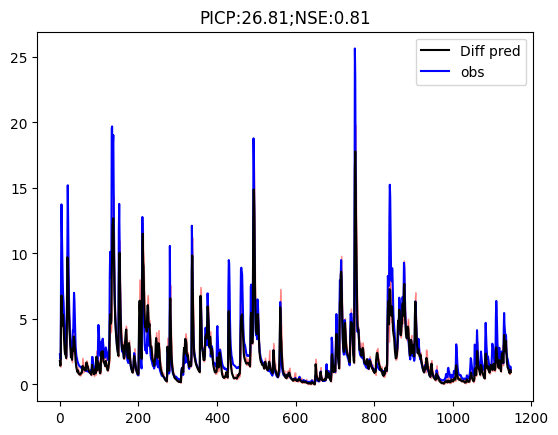

In [ ]:
#%%
array_total=np.asarray(list_)
median=np.median(array_total,axis=0)
up=np.percentile(array_total,95,axis=0)
down=np.percentile(array_total,5,axis=0)
samples_array=np.asarray(median)



target=yy_*std_q+mean_q
pred_=median*std_q+mean_q
pred_low=down*std_q+mean_q
pred_up=up*std_q+mean_q





picp,width=reliability_quantile(target,pred_up,pred_low)
nse_pred=nash(target,pred_)


#%%
plt.plot(pred_,'k',zorder=4,label='Diff pred')
plt.plot(target,'b',zorder=3,label='obs')
#plt.plot(mean_,'green',zorder=2)
plt.fill_between(np.arange(len(pred_)),pred_low.ravel(),pred_up.ravel(),color='r',alpha=0.4,zorder=1)
plt.title('PICP:%1.2f;'%(picp)+ 'NSE:%1.2f'%(nse_pred))
plt.legend()